<a href="https://colab.research.google.com/github/VenkteshV/Question_duplicate_detection/blob/main/Week7/Jacc_similarity_EM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv("drive/My Drive/Extramarks Project/Dataset versions/JEE-ans-no_num-no_fillBlank-replaced_ofthefollowing", index_col = 0 )

In [4]:
df.head()

,question_id,question,syllabus_id,answer,question_type
0,2073346,how many π bonds are present in ferrocene,700295,a,Subjective Question
1,2073324,what is covalency of chlorine atom in second e...,698013,a,Subjective Question
2,2073225,in solid x atoms goes to corner of the cube an...,700078,No of x atoms 8 18 2 12 2,Subjective Question
3,2073215,calculate value of x y here x and y are the to...,697895,stryde images 2022 04 11 202204110162130016496...,Subjective Question
4,2073202,in phosphorus acid if x is number of non bondi...,697895,stryde images 2022 04 11 202204119693370016496...,Subjective Question


In [5]:
print("Number of Questions in this pre-processed data :", df.shape[0])
print(df.shape)

Number of Questions in this pre-processed data : 117781
(117781, 5)


In [6]:
print(df.isnull().sum())
df = df.dropna()   # Should have dropped single choice questions though
print(df.isnull().sum())

question_id        0
question           0
syllabus_id        0
answer           544
question_type      0
dtype: int64
question_id      0
question         0
syllabus_id      0
answer           0
question_type    0
dtype: int64


In [7]:
# Data we're working with currently
df['question_type'].value_counts()

Single Choice Question      75424
Subjective Question         41051
Multiple Choice Question      599
Integer Question              163
Name: question_type, dtype: int64

In [8]:
df['syllabus_id'].value_counts()

446       997
4154      343
395       337
4183      328
3790      305
         ... 
734039      1
730264      1
756047      1
700543      1
731528      1
Name: syllabus_id, Length: 6311, dtype: int64

In [9]:
single_choice_ques_df = df[df['question_type'] == 'single choice question']
subjective_ques_df = df[df['question_type'] == 'subjective_question']
multiple_choice_ques_df = df[df['question_type'] == 'multiple choice question']
integer_question = df[df['question_type'] == 'integer question']

In [10]:
# Character length of a question
df["len"] = df["question"].str.len()-1

In [11]:
# Number of words
df["words"] = df["question"].str.strip().str.split().str.len()

In [12]:
# Number of common words

def to_lower(d):
  a = [[x.lower() for x in s] for s in d]
  return a 

def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1|w2))

Minimum characters 1
Maximum characters 4919
Average number of characters 79


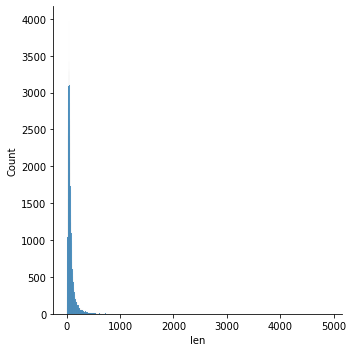

In [13]:
# Question lengths statistics

sns.displot(df['len'])
print('Minimum characters',df['len'].min())
print('Maximum characters',df['len'].max())
print('Average number of characters',int(df['len'].mean()))

In [14]:
df

,question_id,question,syllabus_id,answer,question_type,len,words
0,2073346,how many π bonds are present in ferrocene,700295,a,Subjective Question,41,8
1,2073324,what is covalency of chlorine atom in second e...,698013,a,Subjective Question,58,10
2,2073225,in solid x atoms goes to corner of the cube an...,700078,No of x atoms 8 18 2 12 2,Subjective Question,126,25
3,2073215,calculate value of x y here x and y are the to...,697895,stryde images 2022 04 11 202204110162130016496...,Subjective Question,156,28
4,2073202,in phosphorus acid if x is number of non bondi...,697895,stryde images 2022 04 11 202204119693370016496...,Subjective Question,143,32
...,...,...,...,...,...,...,...
134426,420545,a dice is rolled thrice the probability of get...,-1,frac 5 24,Single Choice Question,114,21
134427,420544,a dice is rolled thrice the probability of get...,-1,frac 5 24,Single Choice Question,114,21
134428,420543,subjective english question,-1,answer_subjective,Subjective Question,27,3
134429,415580,question subjective english,-1,answer subjective hindi,Subjective Question,27,3


In [15]:
print(len(df))

117237


In [16]:
# Questions with len = 1,2,3 Are they of any use ?
df = df.drop(df[df['len'] <= 5].index)
print(len(df))

117131


In [17]:
# Questions with words = 1,2,3 Are they of any use, seems useful ? yes some seems useful
df = df.drop(df[df['words'] < 2].index)
print(len(df))

117069


In [18]:
df=df.reset_index()
df = df.drop('index', axis = 1)

In [19]:
to_keep = []
             #  getting rid of sentences like "h e l l o w o r l d"
             #  also store the following types of questions: "what is incorrect "
             #  "what is not correct "
             #  "among the following"

for index, row in df.iterrows():
  ques = row['question'].lower()
  n_words = len(ques.split())
  len_sent = len(ques)

  res = True
  if n_words/len_sent*100 > 40:
    res = False

  if ques.find("among") != -1 and ques.find("following") != -1 :
    res = False
  if ques.find("what is") != -1 and ques.find("correct") != -1:
    res = False
  if ques.find("what is") != -1 and  ques.find("incorrect") != -1:
    res = False

  to_keep.append(res)

In [20]:
len(df)

117069

In [21]:
df = df[to_keep]

In [22]:
df.to_csv("drive/My Drive/Extramarks Project/Dataset versions/JEE-ans-no_num-no_fillBlank-replaced_ofthefollowing-removed_one_letter_sent_also.csv")

In [23]:
from collections import OrderedDict
import operator
import nltk
from nltk import bigrams, trigrams, word_tokenize
from collections import Counter, defaultdict
nltk.download('punkt')
from re import search

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
ques = df['question'].tolist()
ans = df['answer'].tolist()
types = df['question_type'].tolist()

appended = []

for i in range(len(ques)):
    ques[i] = ques[i].lower()
    ans[i] = str(ans[i]).lower()
    types[i] = types[i].lower()

In [25]:
def A(sent) :
  return (search("following",sent) or search("select",sent) or search("choose",sent))!=None

def B(sent) :
  return (search("statement",sent) or search("option",sent) or search("compound",sent) or search("match",sent) or search("order",sent)) != None

def C(sent) :
  options = ["correct" ,"incorrect", "true", "false", "wrong", "least", "most"]
  for i in options :
    if(search(i,sent)):
      return 1 
  return 0

# def D(qtype) :
#   return qtype == "single choice question" or qtype == "multiple choice question" 

def E(sent) :
  if (search("which of the following",sent)):
    return 1
  return 0

def need_to_append_answer(sent,qtype) :
  return (((A(sent) + B(sent) + C(sent) >= 2)) or E(sent))

for i in range(len(ques)):
    if(need_to_append_answer(ques[i],types[i])):
      ques[i] = ques[i]+" "+ans[i] 
      appended.append(1)
    else:
      appended.append(0)

print(len(appended))
print(len(pd.Series(appended)[pd.Series(appended) == 1])/len(appended))

114803
0.055460223164899874


In [26]:
unigrams = []

for sent in ques :
  unigrams.append(set(nltk.word_tokenize(sent)))

In [27]:
grouped = df.groupby('syllabus_id')

There are 6304 categories

In [28]:
df['syllabus_id'].value_counts()

446       988
4154      343
395       333
4183      326
4147      293
         ... 
700467      1
756046      1
733270      1
733264      1
449203      1
Name: syllabus_id, Length: 6200, dtype: int64

#### Taking attention of syllabus_id

In [29]:
iteration = 1
threshold = 0.7
req_pairs = []
for name, group in grouped:
  if iteration < 4:
    iteration+=1
    continue
  print("Name: ", name)
  print("Iteraiton: ", iteration)
  if iteration > 10:
    break
  sz= len(group)
  for i in range(0,sz-1):
    s1 = set(nltk.word_tokenize(group.iloc[i]['question']))
    # print("s1: ", s1)
    for j in range(i+1,sz):
      s2 = set(nltk.word_tokenize(group.iloc[j]['question']))
      # print("s2: ", s2)
      union = len(s1|s2)
      common = len(s1&s2)
      jaccard_sim =  common/union
      if(jaccard_sim >= threshold):
        req_pairs.append([
              group.iloc[i]['syllabus_id'],
              group.iloc[i]['question'],
              group.iloc[j]['question'],
              group.iloc[i]['question_id'],
              group.iloc[j]['question_id']
        ])
  iteration+=1

Name:  120426
Iteraiton:  4
Name:  13346
Iteraiton:  5
Name:  133762
Iteraiton:  6
Name:  133907
Iteraiton:  7
Name:  133919
Iteraiton:  8
Name:  135222
Iteraiton:  9
Name:  14530
Iteraiton:  10
Name:  14537
Iteraiton:  11


In [30]:
req_pairs_df = pd.DataFrame(req_pairs, columns = ['syllabus_id','ques1', 'ques2', 'ques1_id', 'ques2_id'])
req_pairs_df.to_csv("drive/My Drive/Extramarks Project/Dataset versions/Model1-Semantic/Same_repository_id.csv")
req_pairs_df

,syllabus_id,ques1,ques2,ques1_id,ques2_id
0,13346,if a horizontal line intersects the graph of a...,if a function is one to one then a horizontal ...,1227794,1225002
1,13346,what is a horizontal line test,what is the horizontal line test,897706,855754
2,13346,define inverse function,define inverse function,855758,850316
3,13346,what is invertible,what is invertible,855756,850317
4,13346,what is the condition for f to have a valid in...,what is the condition for f to have a valid in...,855755,850318
...,...,...,...,...,...
120,14530,what is the difference between speed and veloc...,what is the difference between speed and veloc...,660435,2023025
121,14530,define the terms i distance and ii displacemen...,define the terms i distance and ii displacemen...,660419,2023054
122,14530,define i scalar quantities ii vector quantitie...,define i scalar quantities ii vector quantitie...,660409,1578518
123,14530,define non uniform motion,define uniform motion,660397,660275


In [31]:
len(df)

114803

#### Ignoring syllabus_ids

In [32]:
# df

In [33]:
ALL_question_ids = list(df['question_id'])
ALL_syllabus_id = list(df['syllabus_id'])

In [34]:
ALL_syllabus_id[44]

'700313'

In [35]:
len(ALL_syllabus_id)

114803

In [ ]:
sz = len(df)
req_pairs2 = []
threshold = 0.7
for i in tqdm(range(0,20000)):
  s1 = unigrams[i]
  for j in range(i+1,sz):
    # if((j % 10000) == 0):
    #   print("   J: ", j)
    s2 = unigrams[j]
    union = len(s1|s2)
    common = len(s1&s2)
    jaccard_sim =  common/union
    if(jaccard_sim >= threshold):
      i2 = (ALL_syllabus_id[i],ALL_syllabus_id[j])
      j2 = (ques[i],ques[j])
      k2 = (ALL_question_ids[i], ALL_question_ids[j])
      req_pairs2.append([ALL_syllabus_id[i],ALL_syllabus_id[j],ques[i],ques[j],ALL_question_ids[i], ALL_question_ids[j]])

 12%|█▏        | 2381/20000 [09:34<1:14:49,  3.92it/s]

In [ ]:
duplicate_pairs = pd.DataFrame(req_pairs2, columns = ['syllabus_id1','syllabus_id2', 'ques1','ques2','question_id1','question_id2'])
duplicate_pairs.to_csv("drive/My Drive/Extramarks Project/Dataset versions/Model1-Semantic/Jacc_sim_ignore_syllabus.csv")
duplicate_pairs

### **Word share / Jaccard Similarity Plot**

In [ ]:
sns.distplot(df[df['is_duplicate'] == 0]['word_share'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['word_share'],label='duplicate')
plt.legend()
plt.show()

## **Some data eyeballing to the cases where `word share is high` but still they are `not duplicates`.**

- **Note** : `Word_share = Jaccard Similarity (JC)`

- Number of shared terms over the number of all unique terms in both strings 





In [ ]:
vis_df = df.loc[(df['word_share'] == 1) & (df['is_duplicate']==0)]
vis_df[['question1','question2','word_share','is_duplicate']]

⚡ Though questions have `Exact same (JC = 1)` vocabulary but `ordering` changes the meaning completely. This is where sementic nature is required to identify duplicates better.  

> Example : 
> - a) What kind of Asian guys do White girls like ?
> - b) What kind of Asian girls do White guys like ?

> Though some labels I feel are not appropriate and they should be duplicate indeed.
> - a) Which laptop I should buy ?
> - b) Which laptop should I buy ?

In [ ]:
vis_df = df.loc[(df['word_share'] >= 0.9) & (df['is_duplicate']==0)]
vis_df[['question1','question2','word_share','is_duplicate']]

# Use inetractive table and sort acc to word_share values to see 0.9 word_share values first

⚡ Though questions have `High word_share(JC)` vocabulary but a change of `Keyword` in the question changes it meaning.  

> Example : Negation sentences 
> - a) Who are the best science reporters not writing in English ?
> - b) Who are the best science reporters writing in English ?

> Example : Key noun is different 
> - a) How does a typical day in IIM C pass by ?
> - b) How does a typical day in IIM A pass by ?

> Example : More specification gets added
> - a) How much does it cost to study in Canada ?
> - b) How much does it cost to study medicine in Canada ?

In [ ]:
# Some more cases where data is lexically similar but not duplicates

vis_df = df.loc[(df['word_share'] >= 0.75) & (df['is_duplicate']==0)]
vis_df[['question1','question2','word_share','is_duplicate']]

⚡ Though questions have `Moderately high word_share(JC)` but a change of `Keyword` in the question changes it meaning.  

- **Observation** - In this chart we see short sentences whereas earlier there were long sentences, that's because changing a single word in small sentences drops down the Jaccard similarity more (Obvious though).

In [ ]:
# More non-duplicate pairs visualization

threshold = 0.4
df.loc[(df['word_share'] >= threshold)][:200]


## **Some data eyeballing to the cases where `word share is low` but still they are `duplicates`.**

In [ ]:
vis_df = df.loc[(df['word_share'] <= 0.8) & (df['is_duplicate']==1)]
vis_df[['question1','question2','word_share','is_duplicate']][:1000]

What inference can we make from above ?

In [ ]:
# def Unigram_distance(dataset):

#   model = defaultdict(lambda : 0)
#   total_count = 0 
#   for sentence in dataset:
#     sentence = nltk.word_tokenize(sentence)
#     for w1 in sentence:
#       model[w1] += 1
#       total_count += 1 ;

#   for w1 in model:
#       model[w1] /= total_count
  
#   return model

In [ ]:
profile = ProfileReport(df, title="Quora", html={'style':{'full_width':True}})

In [ ]:
profile.to_notebook_iframe()

In [ ]:
# Preprocessing - ? se pehle space daaldo or remove it

In [ ]:
drive.flush_and_unmount()